## Image Transforms

# Question 2
Write python from scratch for computing 2D DFT{X(k,l)} of the following 2D array
- x(m,n) = np.array([[1, 0],[2, 1]])                  
- x(m,n) = np.array([[1,2, 3,4], [5, 6, 7, 8], [9,10,11,12], [13,14,15,16]])

 (b) Verify the results of part (a) by analytical solution method ( i.e. pen and paper based solution)

In [3]:
import numpy as np

In [4]:
def dft_manual(f):
    N1 = f.shape[0] #no of rows
    N2 = f.shape[1] #no of cols
    U = np.arange(N2)  #row basis
    V = np.arange(N1)  #col basis
    
    #row wise 1D DFT
    fxv = np.array([[np.around(np.sum(np.exp(V*2j*np.pi*v/N1)*f[y]), 4) for v in range(N2)] for y in range(N1)])
    fuv = 1/N1*np.array([[np.around(np.sum(np.exp(U*2j*np.pi*u/N2)*fxv[:,x]), 4) for u in range(N1)] for x in range(N2)]).T
    
    if N1 != N2:
        fuv = fuv/N2
    return fuv

In [5]:
f1 = np.array([[1,0], 
             [2,1]])
f2 =  np.array([[1,2, 3,4], [5, 6, 7, 8], [9,10,11,12], [13,14,15,16]])

f1_dft = dft_manual(f1)
f2_dft = dft_manual(f2)
print('(i) f1 = \n', f1)
print('DFT of f1 = \n', f1_dft)
print('\n \n')
print('(ii) f2 = \n', f2)
print('DFT of f2 =\n', f2_dft)

(i) f1 = 
 [[1 0]
 [2 1]]
DFT of f1 = 
 [[ 2.+0.j  1.+0.j]
 [-1.+0.j  0.+0.j]]

 

(ii) f2 = 
 [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
DFT of f2 =
 [[34.+0.j -2.-2.j -2.+0.j -2.+2.j]
 [-8.-8.j  0.+0.j  0.+0.j  0.+0.j]
 [-8.+0.j  0.+0.j  0.+0.j  0.-0.j]
 [-8.+8.j  0.+0.j  0.-0.j  0.-0.j]]


Verfication sumbitted in PDF

# Question 3
Q.3. (a) Write python from scratch for 2D Circular convolution using  Doubly Block Circulant matrices method between input=np.array([[1,2,3],[4,5,6],[7,8,9]])and filter=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

(b) verify the result of part (a) by  analytical solution method ( i.e. pen and paper-based solution)



In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal
import time
from numpy.lib.stride_tricks import as_strided


### Function to construct Doubly Blocked Circulant Matrix

In [9]:
def doubly_block_circulant(I,F):
    # Input, Output Dimensions
    I_row_num, I_col_num = I.shape 
    F_row_num, F_col_num = F.shape
    output_row_num = I_row_num 
    output_col_num = I_col_num 
    print('Output dimension:', output_row_num, output_col_num)

    # Padding the Filter
    F_zero_padded = np.pad(F, ((output_row_num - F_row_num, 0), (0, output_col_num - F_col_num)),'constant', constant_values=0)
    print('Padded Filter Shape: ', F_zero_padded.shape)
    
    # Use each row of the zero-padded F to create a toeplitz matrix. 
    circulant_list = []
    for i in range(F_zero_padded.shape[0]-1, -1, -1): # iterate from last row to the first row
        c = F_zero_padded[i, :]                       # i th row of the Filter 
        r = np.r_[c[0], np.zeros(I_col_num-1)]        # first row for the toeplitz matrix
        circulant_m = circulant_1d(c)                 # Calling function for 1D toeplitz
        circulant_list.append(circulant_m)
    
    c = range(1, F_zero_padded.shape[0]+1)
    doubly_indices = circulant_1d(c)

    # Initialize doubly blocked matrix with zero values
    circulant_shape = circulant_list[0].shape            # shape of one toeplitz matrix
    h = circulant_shape[0]*doubly_indices.shape[0]
    w = circulant_shape[1]*doubly_indices.shape[1]
    doubly_blocked_shape = [h, w]
    doubly_blocked = np.zeros(doubly_blocked_shape)

    # Stack toeplitz matrices for each row in the doubly blocked matrix
    b_h, b_w = circulant_shape 
    for i in range(doubly_indices.shape[0]):
        for j in range(doubly_indices.shape[1]):
            start_i = i * b_h
            start_j = j * b_w
            end_i = start_i + b_h
            end_j = start_j + b_w
            doubly_blocked[start_i: end_i, start_j:end_j] = circulant_list[doubly_indices[i,j]-1]

    print('Shape of doubly_blocked Toeplitz Matrix is : ', doubly_blocked.shape)
#     print('doubly_blocked Toeplitz Matrix is: ', doubly_blocked)
    return doubly_blocked


### Multiply doubly blocked toeplitz matrix with vectorized input signal

In [10]:
def circulant_conv2d(doubly_blocked, I, F):
    
    # Converting input to vector
    vectorized_I = matrix_to_vector(I)
#     print('Vectorized Input: ', vectorized_I)

    # Result of convolution by matrix mupltiplication
    result_vector = np.matmul(doubly_blocked, vectorized_I)
    
    output_row_num = I.shape[0]
    output_col_num = I.shape[1]
    

    # reshape the raw result to desired matrix form
    out_shape = [output_row_num, output_col_num]
    my_output = vector_to_matrix(result_vector, out_shape)
    
    return my_output

#     print('Result of Convolution using doubly blocked Toeplitz method: \n', my_output)

### Helper Functions

In [11]:
# 1D Circulant Matrix Construction 
def circulant_1d(c):
    c = np.asarray(c).ravel()
    c_ext = np.concatenate((c[::-1], c[:0:-1]))
    L = len(c)
    n = c_ext.strides[0]
    return as_strided(c_ext[L-1:], shape=(L, L), strides=(-n, n)).copy()

#Converting matrix to vector
def matrix_to_vector(input):
    input_h, input_w = input.shape
    output_vector = np.zeros(input_h*input_w, dtype=input.dtype)
    input = np.flipud(input) 
    for i,row in enumerate(input):
        st = i*input_w
        nd = st + input_w
        output_vector[st:nd] = row
        
    return output_vector

#Converting vector to matrix
def vector_to_matrix(input, output_shape):
    output_h, output_w = output_shape
    output = np.zeros(output_shape, dtype=input.dtype)
    for i in range(output_h):
        st = i*output_w
        nd = st + output_w
        output[i, :] = input[st:nd]
    # flip the output matrix up-down to get correct result
    output=np.flipud(output)
    return output

## Question 3 - Conv using Doubly Circulant Matrix between input array and filter

In [12]:
# input signal
I = np.array([[1,2,3],[4,5,6],[7,8,9]])
print('I: ', I.shape)
print(I)

# filter 
F = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
print('F: ',F.shape)
print(F)

I:  (3, 3)
[[1 2 3]
 [4 5 6]
 [7 8 9]]
F:  (3, 3)
[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]


In [13]:
doubly_blocked = doubly_block_circulant(I,F) # Doubly Blocked Circulant Matrix

Output dimension: 3 3
Padded Filter Shape:  (3, 3)
Shape of doubly_blocked Toeplitz Matrix is :  (9, 9)


In [14]:
conv2d_result = circulant_conv2d(doubly_blocked, I, F) # Convolution Result
conv2d_result

array([[ 24.,  24.,  24.],
       [-12., -12., -12.],
       [-12., -12., -12.]])

## Question 4

Q.4.  (i) Write python from scratch for 2D DCT   transform  on the following matrix:
 - (a)  f(m.n) = [ 90, 100 ; 100,  175]  
 - (b) f(m.n) = [ 10, 20,  30; 40  50 60  ; 70 80, 90; 100, 110, 120; 130 140, 150]  and also comment on energy compaction property  of DCT 
 - (c)   f(m.n)= monalisa.tif 

(ii) Write python from scratch for 2D IDCT   transform  and reconstruct f(m,n) from  part(i)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ques_1 = np.array([[90,100],[100,175]])
ques_1

array([[ 90, 100],
       [100, 175]])

In [3]:
ques_2 = np.array([[10, 20, 30],[40, 50, 60], [70, 80, 90], [100, 110 ,120], [130, 140, 150]])
ques_2

array([[ 10,  20,  30],
       [ 40,  50,  60],
       [ 70,  80,  90],
       [100, 110, 120],
       [130, 140, 150]])

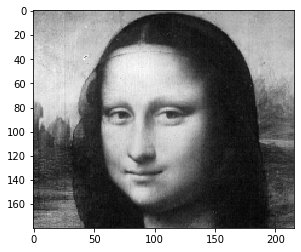

In [4]:
ques_3 = plt.imread('monalisa.gif')
plt.imshow(ques_3,cmap = 'gray')
plt.show()

### Question 4: DCT and IDCT of 4 (i) and 4 (ii)

In [5]:
def get_coef_matrix(N):   ## Get DCT coefficients
    C = np.zeros((N,N))
    alpha_N = [np.sqrt(1/N)] + [np.sqrt(2/N)]*(N-1)

    for k in range(N):
        for l in range(N):
            C[k,l] = alpha_N[k] * np.cos((2*l+1)*k*np.pi/2/N)
    return C

In [6]:
def DCT(x):
    
    C_1 = get_coef_matrix(x.shape[0])
    C_2 = get_coef_matrix(x.shape[1])
    DCT_x = np.matmul(np.matmul(C_1,x),C_2.T)
    return DCT_x

def IDCT(x):
    
    C_1 = get_coef_matrix(x.shape[0])
    C_2 = get_coef_matrix(x.shape[1])
    IDCT_x = np.matmul(np.matmul(C_1.T,x),C_2)

    return IDCT_x

#### Question 4 (i)

In [7]:
x = ques_1
DCT_x = DCT(x)
IDCT_DCT_x = IDCT(DCT_x)

print("DCT:\n", DCT_x)
print("\nIDCT:\n", IDCT_DCT_x)
print("\nOriginal Input:\n", x)

print("\nMean Squared Error: ", np.mean((IDCT_DCT_x - x)**2))

DCT:
 [[232.5 -42.5]
 [-42.5  32.5]]

IDCT:
 [[ 90. 100.]
 [100. 175.]]

Original Input:
 [[ 90 100]
 [100 175]]

Mean Squared Error:  1.8175355256292112e-27


#### Question 4 (ii)

In [8]:
x = ques_2

DCT_x = DCT(x)
IDCT_DCT_x = IDCT(DCT_x)

print("DCT:\n", DCT_x)
print("\nIDCT:\n", IDCT_DCT_x)
print("\nOriginal Input:\n", x)

print("\nMean Squared Error: ", np.mean((IDCT_DCT_x - x)**2))

DCT:
 [[ 3.09838668e+02 -3.16227766e+01  5.21116188e-14]
 [-1.63652815e+02 -7.25698306e-15 -1.18578533e-14]
 [-2.61522925e-14 -5.65233285e-15 -3.15544362e-30]
 [-1.47565651e+01  9.27268770e-16 -4.25619706e-15]
 [-3.83951550e-14  4.63177275e-15  2.90077857e-15]]

IDCT:
 [[ 10.  20.  30.]
 [ 40.  50.  60.]
 [ 70.  80.  90.]
 [100. 110. 120.]
 [130. 140. 150.]]

Original Input:
 [[ 10  20  30]
 [ 40  50  60]
 [ 70  80  90]
 [100 110 120]
 [130 140 150]]

Mean Squared Error:  1.1698281317157458e-27


### Question 4 (iii): DCT and IDCT of monalisa.gif
<a id='DCT'></a>

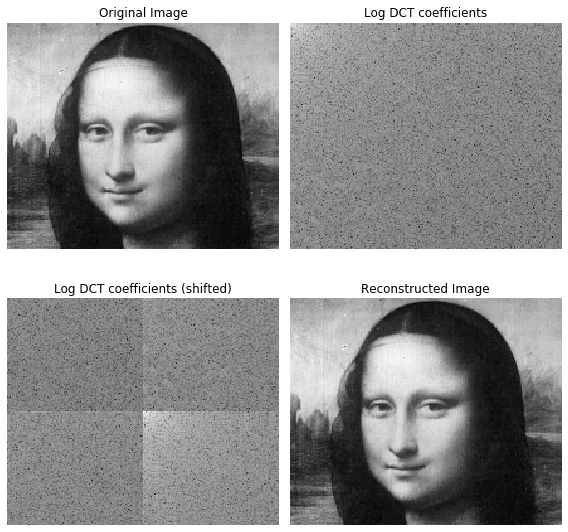

Mean Square Error:  5.341215946519953e-24


In [9]:
x = ques_3

DCT_x = DCT(x)
IDCT_DCT_x = IDCT(DCT_x)

vis_img = np.log(abs(DCT_x)) ## Take log to visualise

fig, axs = plt.subplots(2,2,figsize= (8,8),tight_layout = True)
axs = axs.ravel()
axs[0].imshow(x,cmap = 'gray')
axs[1].imshow(vis_img,cmap = 'gray')
axs[2].imshow(np.fft.fftshift(vis_img),cmap = 'gray')
axs[3].imshow(IDCT_DCT_x,cmap = 'gray')
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[0].set_title('Original Image')
axs[1].set_title('Log DCT coefficients')
axs[2].set_title('Log DCT coefficients (shifted)')
axs[3].set_title('Reconstructed Image')

plt.show()
print("Mean Square Error: ", np.mean((IDCT_DCT_x - x)**2))

## Energy compaction of DCT

Energy compaction means a large proportion of the total energy is contained in a few coefficients. Compared to the energy distribution of the input signal, the DCT transformed image has the energy concentrated in a small region. For correlated images, DCT provides excellent energy compaction. The energy of the correlated image is packed into the low frequency region (top left region in the DCT figure). For uncorrelated images, however, the energy is spread out and the energy compaction is low.

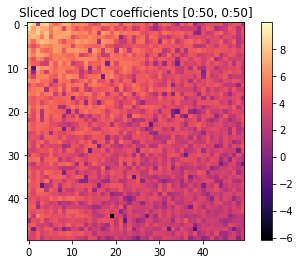

In [10]:
plt.imshow(vis_img[0:50,0:50],cmap = 'magma')
plt.colorbar()
plt.title('Sliced log DCT coefficients [0:50, 0:50]')
plt.show()

### Reconstruction

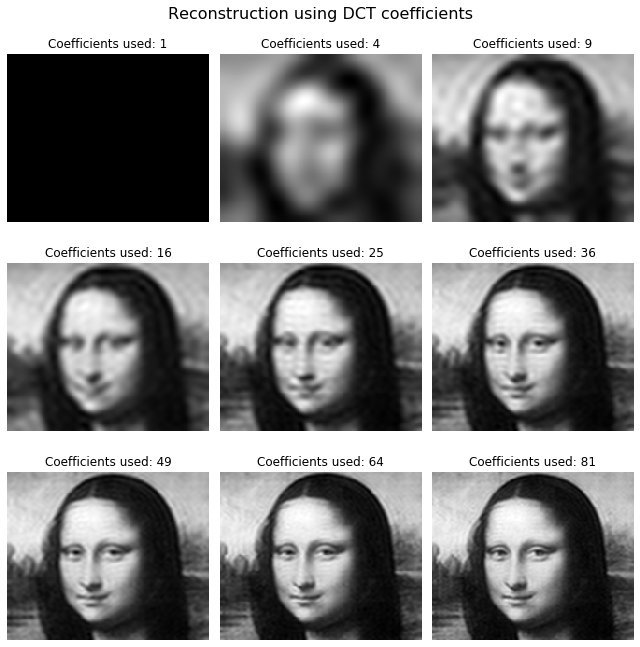

In [11]:
t_x = DCT_x                               ## Transmitted matrix
x = np.zeros(ques_3.shape)

fig, axs = plt.subplots(3,3,figsize= (9,9),tight_layout = True)
axs  = axs.ravel()
for i in range(9):
    
    x[0:10*i,0:10*i] = t_x[0:10*i,0:10*i]
    IDCT_DCT_x = IDCT(x)
    
    axs[i].imshow(IDCT_DCT_x,cmap = 'gray')
    axs[i].set_title('Coefficients used: ' + str((i+1)**2))
    axs[i].axis('off')

plt.suptitle('Reconstruction using DCT coefficients',size = 16, y = 1.02)
plt.show()